In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch.utils.data import DataLoader, TensorDataset

# --- データ作成（わざと難しい“半月型”） ---
X, y = make_moons(n_samples=5000, noise=0.2)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)

# --- モデル定義（BNあり / BNなし） ---
class MLP(nn.Module):
    def __init__(self, use_bn=False):
        super().__init__()
        layers = []
        layers += [nn.Linear(2, 64)]
        if use_bn:
            layers += [nn.BatchNorm1d(64)]
        layers += [nn.ReLU()]

        layers += [nn.Linear(64, 64)]
        if use_bn:
            layers += [nn.BatchNorm1d(64)]
        layers += [nn.ReLU()]

        layers += [nn.Linear(64, 2)]
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

# --- 2つのモデル ---
model_no_bn = MLP(use_bn=False)
model_bn    = MLP(use_bn=True)

opt1 = optim.Adam(model_no_bn.parameters(), lr=0.00002)
opt2 = optim.Adam(model_bn.parameters(), lr=0.00002)

criterion = nn.CrossEntropyLoss()

# --- 学習 ---
epochs = 50
loss_no_bn_list = []
loss_bn_list = []

for epoch in range(epochs):
    total_no_bn = 0
    total_bn    = 0

    for batch_x, batch_y in loader:
        # --- BNなしモデル ---
        opt1.zero_grad()
        preds1 = model_no_bn(batch_x)
        loss1 = criterion(preds1, batch_y)
        loss1.backward()
        opt1.step()
        total_no_bn += loss1.item()

        # --- BNありモデル ---
        opt2.zero_grad()
        preds2 = model_bn(batch_x)
        loss2 = criterion(preds2, batch_y)
        loss2.backward()
        opt2.step()
        total_bn += loss2.item()

    loss_no_bn_list.append(total_no_bn / len(loader))
    loss_bn_list.append(total_bn / len(loader))

    print(f"Epoch {epoch+1}/{epochs} | No BN Loss: {loss_no_bn_list[-1]:.4f}, BN Loss: {loss_bn_list[-1]:.4f}")




Epoch 1/50 | No BN Loss: 0.6998, BN Loss: 0.7247
Epoch 2/50 | No BN Loss: 0.6835, BN Loss: 0.6069
Epoch 3/50 | No BN Loss: 0.6671, BN Loss: 0.5111
Epoch 4/50 | No BN Loss: 0.6519, BN Loss: 0.4450
Epoch 5/50 | No BN Loss: 0.6363, BN Loss: 0.3962
Epoch 6/50 | No BN Loss: 0.6211, BN Loss: 0.3624
Epoch 7/50 | No BN Loss: 0.6047, BN Loss: 0.3323
Epoch 8/50 | No BN Loss: 0.5885, BN Loss: 0.3121
Epoch 9/50 | No BN Loss: 0.5723, BN Loss: 0.3011
Epoch 10/50 | No BN Loss: 0.5562, BN Loss: 0.2868
Epoch 11/50 | No BN Loss: 0.5393, BN Loss: 0.2738
Epoch 12/50 | No BN Loss: 0.5222, BN Loss: 0.2582
Epoch 13/50 | No BN Loss: 0.5068, BN Loss: 0.2540
Epoch 14/50 | No BN Loss: 0.4891, BN Loss: 0.2426
Epoch 15/50 | No BN Loss: 0.4725, BN Loss: 0.2356
Epoch 16/50 | No BN Loss: 0.4557, BN Loss: 0.2321
Epoch 17/50 | No BN Loss: 0.4408, BN Loss: 0.2265
Epoch 18/50 | No BN Loss: 0.4261, BN Loss: 0.2201
Epoch 19/50 | No BN Loss: 0.4123, BN Loss: 0.2134
Epoch 20/50 | No BN Loss: 0.3993, BN Loss: 0.2104
Epoch 21/

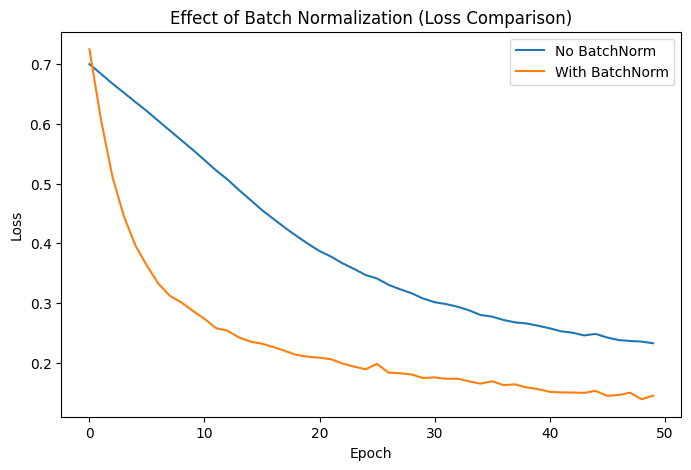

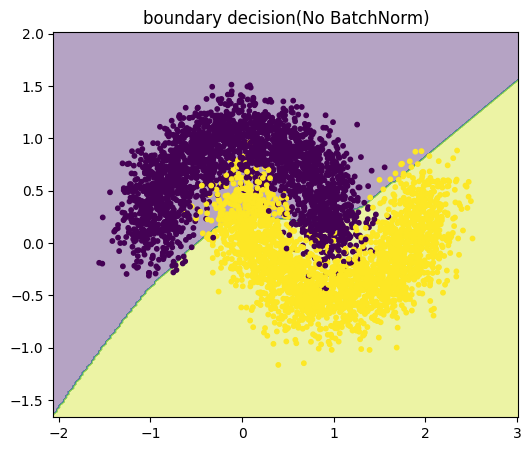

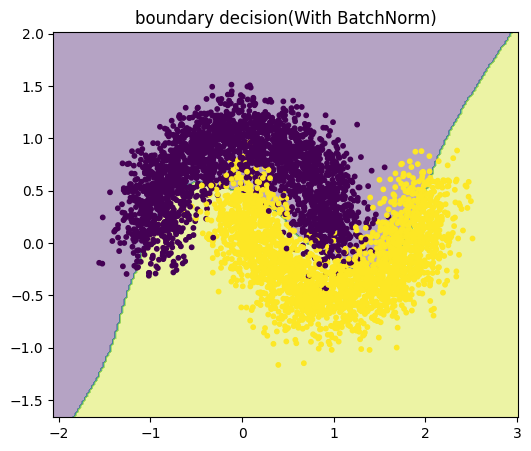

In [11]:
# --- Loss可視化 ---
plt.figure(figsize=(8,5))
plt.plot(loss_no_bn_list, label="No BatchNorm")
plt.plot(loss_bn_list, label="With BatchNorm")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Effect of Batch Normalization (Loss Comparison)")
plt.legend()
plt.show()

# --- 決定境界の可視化 ---
import numpy as np

def plot_decision_boundary(model, title):
    x_min, x_max = X[:,0].min() - .5, X[:,0].max() + .5
    y_min, y_max = X[:,1].min() - .5, X[:,1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                         np.linspace(y_min, y_max, 200))
    grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    Z = model(grid).argmax(dim=1).reshape(xx.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(xx, yy, Z, alpha=0.4)
    plt.scatter(X[:,0], X[:,1], c=y, s=10)
    plt.title(title)
    plt.show()

plot_decision_boundary(model_no_bn, "boundary decision(No BatchNorm)")
plot_decision_boundary(model_bn, "boundary decision(With BatchNorm)")

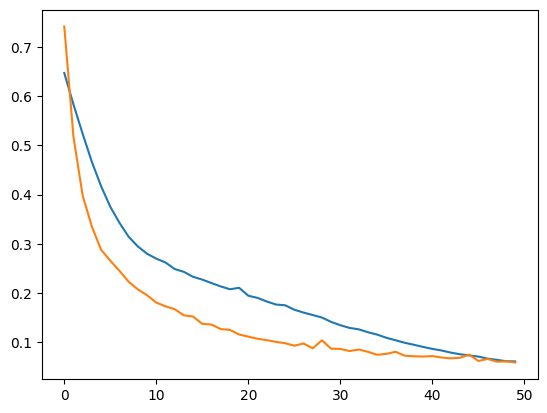

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# ----------------------
# MLP モデル（BNあり / なし）
# ----------------------
class MLP(nn.Module):
    def __init__(self, use_bn=False):
        super().__init__()
        layers = []

        layers += [nn.Linear(2, 64)]
        if use_bn:
            layers += [nn.BatchNorm1d(64)]
        layers += [nn.ReLU()]

        layers += [nn.Linear(64, 64)]
        if use_bn:
            layers += [nn.BatchNorm1d(64)]
        layers += [nn.ReLU()]

        layers += [nn.Linear(64, 2)]

        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)


# ----------------------
# データ生成（例：2クラスのmoon）
# ----------------------
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler

X, y = make_moons(n_samples=5000, noise=0.15)

# ★ データ標準化（必須）
scaler = StandardScaler()
X = scaler.fit_transform(X)

X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

dataset = TensorDataset(X, y)
loader = DataLoader(dataset, batch_size=64, shuffle=True)


# ----------------------
# 学習関数
# ----------------------
def train(model, title):
    model.train()
    opt = optim.Adam(model.parameters(), lr=5e-5)
    criterion = nn.CrossEntropyLoss()

    losses = []

    for epoch in range(50):
        total_loss = 0
        for batch_x, batch_y in loader:
            opt.zero_grad()
            out = model(batch_x)
            loss = criterion(out, batch_y)
            loss.backward()
            opt.step()
            total_loss += loss.item()

        losses.append(total_loss / len(loader))

    # 学習曲線を表示
    plt.plot(losses, label=title)


# ----------------------
# 学習
# ----------------------
model_no_bn = MLP(use_bn=False)
model_bn    = MLP(use_bn=True)

train(model_no_bn, "No BatchNorm")
train(model_bn, "With BatchNorm")



/tmp/ipython-input-2883458842.py:3: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 26377 (\N{CJK UNIFIED IDEOGRAPH-6709}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 28961 (\N{CJK UNIFIED IDEOGRAPH-7121}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 12395 (\N{HIRAGANA LETTER NI}) missing from font(s) DejaVu Sans.
  fig.canvas.

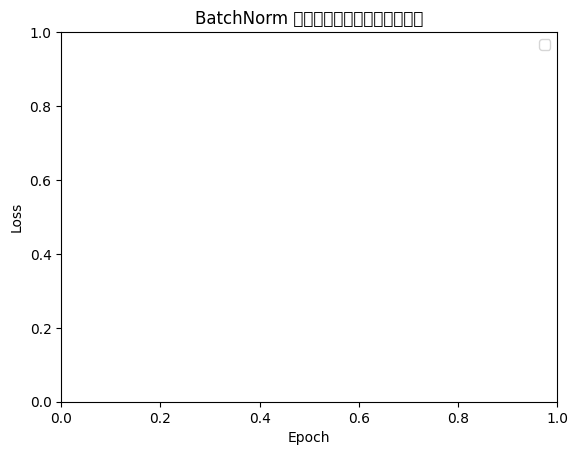

In [6]:

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("BatchNorm の有無による学習曲線の比較")
plt.show()